In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np
import scipy.io
from torch import nn
from matplotlib import pyplot as plt
from torch import optim

In [2]:
input_mel=np.load('all_mel.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
output_label=np.load('label_data.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
output_label= output_label.reshape(-1)
output_label=np.array(output_label,dtype=np.int64);

## data split

In [3]:
from sklearn.model_selection import train_test_split

mel = input_mel
label = output_label

# shuffle = False

mel_train, mel_test, label_train, label_test = train_test_split(mel, 
                                                    label, 
                                                    test_size=0.25,                    
                                                    random_state=123)

mel_train = np.reshape(mel_train,(21290,1,101,101))
mel_test = np.reshape(mel_test,(7097,1,101,101))

X_train = torch.Tensor(mel_train);
X_test = torch.Tensor(mel_test);
y_train = torch.LongTensor(label_train);
y_test = torch.LongTensor(label_test);

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

## Modeling

In [4]:
# dataset 함수 정의
def create_datasets(batch_size):
    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.3

    # torch.FloatTensor로 변환
    transform = transforms.ToTensor()

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(ds_train)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    loader_train = torch.utils.data.DataLoader(ds_train,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    loader_valid = torch.utils.data.DataLoader(ds_train,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    loader_test = torch.utils.data.DataLoader(ds_test,
                                              batch_size=batch_size,
                                              num_workers=0)

    return loader_train, loader_valid, loader_test


# CNN 모델 정의
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2))

    
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2))
   
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        
        # flatten
        self.flatten=nn.Flatten()

        # 전결합층 6x6x64 inputs -> 4 outputs
        self.fc = torch.nn.Linear(6*6*64, 4, bias=True)
        


        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.flatten(out)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

# overfitting 방지를 위한 EarlyStopping 정의

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



        
        
train_accus = []        
valid_accus = []
        
# train 함수 정의
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []
    
    correct_train=0
    correct_val = 0
    total_train = 0
    total_val = 0
    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):
        print(f"======================[Epoch {epoch:2d}]======================")
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, targets) in enumerate(loader_train, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            outputs = model(data)
            # calculate the loss
            loss = loss_fn(outputs,targets.flatten())
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct_train += predicted.eq(targets.data.view_as(predicted)).sum()
            total_train += targets.data.size(0)
            train_losses.append(loss.item())
            print(f'\r {batch}/{len(loader_train)}', end='')

        train_accu=100.*correct_train/total_train
        train_accus.append(train_accu)    
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data , targets in loader_valid :
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            outputs = model(data)
            # calculate the loss
            loss = loss_fn(outputs,targets.flatten())

            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct_val += predicted.eq(targets.data.view_as(predicted)).sum()
            total_val += targets.data.size(0)
            # record validation loss
            valid_losses.append(loss.item())
        valid_accu=100.*correct_val/total_val
        valid_accus.append(valid_accu)    
        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))


        print_msg = (f'epoch : [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

   # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

# CNN 모델 정의
model = CNN()

batch_size = 128
n_epochs = 100
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


# dataset 만들기
loader_train, loader_valid, loader_test = create_datasets(batch_size)

# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20



In [5]:
# 학습
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

======================[Epoch  1]======================


C:\Users\jayjo\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 117/117epoch : [  1/100] train_loss: 0.33124 valid_loss: 0.04544
Validation loss decreased (inf --> 0.045444).  Saving model ...
======================[Epoch  2]======================
 117/117epoch : [  2/100] train_loss: 0.05170 valid_loss: 0.03568
Validation loss decreased (0.045444 --> 0.035679).  Saving model ...
======================[Epoch  3]======================
 117/117epoch : [  3/100] train_loss: 0.04013 valid_loss: 0.03244
Validation loss decreased (0.035679 --> 0.032436).  Saving model ...
======================[Epoch  4]======================
 117/117epoch : [  4/100] train_loss: 0.03900 valid_loss: 0.02716
Validation loss decreased (0.032436 --> 0.027156).  Saving model ...
======================[Epoch  5]======================
 117/117epoch : [  5/100] train_loss: 0.03151 valid_loss: 0.02518
Validation loss decreased (0.027156 --> 0.025176).  Saving model ...
======================[Epoch  6]======================
 117/117epoch : [  6/100] train_loss: 0.02916 valid_los

### Train and Validation dataset test

In [6]:

# test 함수 정의
def test1():
    
    # 추론모드로 전환
    model.eval()
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_train:

            outputs = model(data)
            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가
       
    # 정확도 출력
    data_num = len(loader_train.dataset)*0.7  # 데이터 총 건수
    print('\ntrain 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num)) 
    

# test 함수 정의 
def test2():
    
    # 추론모드로 전환
    model.eval()
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_valid:

            outputs = model(data)
            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가
    # 정확도 출력
    data_num = len(loader_train.dataset)*0.3  # 데이터 총 건수
    print('\nvalid 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num)) 

In [7]:
test1()


train 데이터에서 예측 정확도: 14867/14902.999999999998 (100%)



In [8]:
test2()


valid 데이터에서 예측 정확도: 6346/6387.0 (99%)



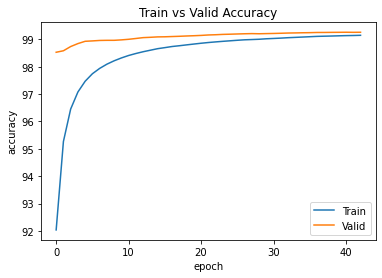

In [9]:
plt.plot(train_accus)
plt.plot(valid_accus)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()


### Test dataset test

In [10]:
test_accus = []
def test3():
    from sklearn.metrics import confusion_matrix
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0
    predicted_total=np.array([0]);
    targets_total=np.array([0]);
    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()# 정답과 일치한 경우 정답 카운트를 증가
            predicted=predicted.numpy()
            predicted=np.reshape(predicted,(-1,1))
            targets=targets.numpy()
            targets=np.reshape(targets,(-1,1))
            predicted_total=np.vstack((predicted_total,predicted));
            targets_total=np.vstack((targets_total,targets));
            predicted_total=predicted_total[1:,:];
            targets_total=targets_total[1:,:];
            cf = confusion_matrix(targets, predicted)

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    cf = confusion_matrix(targets_total, predicted_total)
    print('\ntest 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))
    print("--------------------------------------------------")
    print(cf)
    print("--------------------------------------------------")
    return targets_total, predicted_total



In [11]:
test3()


test 데이터에서 예측 정확도: 7056/7097 (99%)

--------------------------------------------------
[[  41   13   16    0]
 [   8  359    0    0]
 [   4    0 5992    0]
 [   0    0    0  609]]
--------------------------------------------------


(array([[1],
        [2],
        [2],
        ...,
        [3],
        [2],
        [2]], dtype=int64),
 array([[1],
        [2],
        [2],
        ...,
        [3],
        [2],
        [2]], dtype=int64))